In [1]:

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

UNet

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super(UNet, self).__init__()

        # Define a convolutional block: consists of two Conv2d layers and ReLU activation
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU(),  # Activation function
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU()  # Activation function
            )

        # Encoder stage
        self.encoder1 = conv_block(in_channels, 64)  # First encoder block
        self.encoder2 = conv_block(64, 128)  # Second encoder block
        self.encoder3 = conv_block(128, 256)  # Third encoder block

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        # Bottleneck stage
        self.middle = conv_block(256, 512)  # Middle block

        # Decoder stage
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsampling
        self.decoder3 = conv_block(512, 256)  # Decoder block 3

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsampling
        self.decoder2 = conv_block(256, 128)  # Decoder block 2

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsampling
        self.decoder1 = conv_block(128, 64)  # Decoder block 1

        # Output layer: outputting a single channel (e.g., for binary segmentation)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Extract features from the encoder stage
        enc1 = self.encoder1(x)  # First encoder
        enc2 = self.encoder2(self.pool(enc1))  # Second encoder
        enc3 = self.encoder3(self.pool(enc2))  # Third encoder

        # Middle stage
        middle = self.middle(self.pool(enc3))  # Middle block

        # Restore the size of the input image in the decoder stage
        dec3 = self.upconv3(middle)  # Upsampling
        dec3 = self.center_crop(dec3, enc3.size()[2:])  # Crop to match size
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concatenate with encoder feature
        dec3 = self.decoder3(dec3)  # Decoder block 3

        dec2 = self.upconv2(dec3)  # Upsampling
        dec2 = self.center_crop(dec2, enc2.size()[2:])  # Crop to match size
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concatenate with encoder feature
        dec2 = self.decoder2(dec2)  # Decoder block 2

        dec1 = self.upconv1(dec2)  # Upsampling
        dec1 = self.center_crop(dec1, enc1.size()[2:])  # Crop to match size
        dec1 = torch.cat((dec1, enc1), dim=1)  # Concatenate with encoder feature
        dec1 = self.decoder1(dec1)  # Decoder block 1

        output = self.output_conv(dec1)  # Final output
        return output

    def center_crop(self, layer, target_size):
        # Function to center crop the layer to a specific target size
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2  # Calculate vertical difference
        diff_x = (layer_width - target_size[1]) // 2  # Calculate horizontal difference
        return layer[:, :, diff_y:diff_y + target_size[0], diff_x:diff_x + target_size[1]]  # Return cropped layer


ResUNet

In [3]:
import torch
import torch.nn as nn

class ResUNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ResUNet, self).__init__()

        # Define a convolutional block: consists of two Conv2d layers with ReLU activation
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU(inplace=True),  # Activation function
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU(inplace=True)  # Activation function
            )

        # Define a residual block: consists of two Conv2d layers with BatchNorm and ReLU activation
        def residual_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.BatchNorm2d(out_channels),  # Batch normalization
                nn.ReLU(inplace=True),  # Activation function
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.BatchNorm2d(out_channels)  # Batch normalization
            )

        # Encoder stages
        self.encoder1 = conv_block(in_channels, 64)  # First encoder block
        self.encoder2 = conv_block(64, 128)  # Second encoder block
        self.encoder3 = conv_block(128, 256)  # Third encoder block

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer for downsampling

        # Middle stage using a residual block
        self.middle = residual_block(256, 512)  # Bottleneck block

        # Decoder stages
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder3 = conv_block(512, 256)  # Decoder block 3

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder2 = conv_block(256, 128)  # Decoder block 2

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder1 = conv_block(128, 64)  # Decoder block 1

        # Final output layer: outputting the number of channels specified by in_channels
        self.output_conv = nn.Conv2d(64, in_channels, kernel_size=1)

    def forward(self, x):
        # Forward pass through the encoder
        enc1 = self.encoder1(x)  # First encoder
        enc2 = self.encoder2(self.pool(enc1))  # Second encoder
        enc3 = self.encoder3(self.pool(enc2))  # Third encoder

        # Forward pass through the middle stage
        middle = self.middle(self.pool(enc3))  # Bottleneck block

        # Forward pass through the decoder
        dec3 = self.upconv3(middle)  # Upsampling
        dec3 = self.center_crop(dec3, enc3.size()[2:])  # Crop to match size
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concatenate with encoder feature
        dec3 = self.decoder3(dec3)  # Decoder block 3

        dec2 = self.upconv2(dec3)  # Upsampling
        dec2 = self.center_crop(dec2, enc2.size()[2:])  # Crop to match size
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concatenate with encoder feature
        dec2 = self.decoder2(dec2)  # Decoder block 2

        dec1 = self.upconv1(dec2)  # Upsampling
        dec1 = self.center_crop(dec1, enc1.size()[2:])  # Crop to match size
        dec1 = torch.cat((dec1, enc1), dim=1)  # Concatenate with encoder feature
        dec1 = self.decoder1(dec1)  # Decoder block 1

        output = self.output_conv(dec1)  # Final output
        return output

    def center_crop(self, layer, target_size):
        # Function to center crop the layer to a specific target size
        _, _, layer_height, layer_width = layer.size()  # Get the dimensions of the layer
        diff_y = (layer_height - target_size[0]) // 2  # Calculate vertical difference
        diff_x = (layer_width - target_size[1]) // 2  # Calculate horizontal difference
        return layer[:, :, diff_y:diff_y + target_size[0], diff_x:diff_x + target_size[1]]  # Return cropped layer


클래스 이름: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


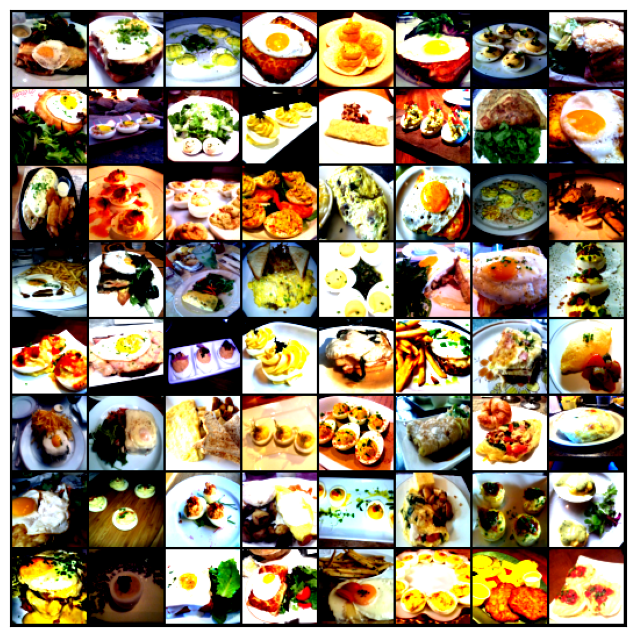

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))

# Define the transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Specify the directory for the training data
data_dir = r".\train"  # Set your own training path here

# Create an ImageFolder dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Check the class names in the dataset
class_names = dataset.classes
print("클래스 이름:", class_names)

# Specify the desired class names to filter
target_classes = ['Egg']  # Choose the target class

# Get the indices of the selected classes
target_indices = [class_names.index(cls) for cls in target_classes]

# Filter the dataset to include only the selected classes
selected_indices = [i for i, (_, label) in enumerate(dataset) if label in target_indices]

# Create a subset of the dataset
train_data = Subset(dataset, selected_indices)

# Create a DataLoader for the training data
train_Loader = DataLoader(train_data, batch_size=256, shuffle=True)

# Function to denormalize images
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# Function to display a batch of images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])  # Remove axis ticks
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))  # Show images in a grid format

# Function to show a batch from the DataLoader
def show_batch(dl, nmax=64):
    for images, _ in dl:  # Get images from the DataLoader
        show_images(images, nmax)  # Display the images
        break  # Exit after showing the first batch

# Display a batch of images from the training DataLoader
show_batch(train_Loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


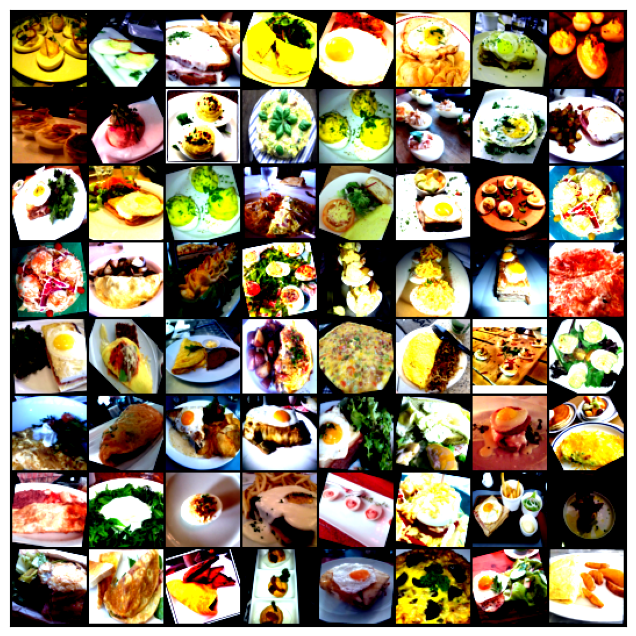

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define a transformation pipeline for data augmentation
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=30),  # Randomly rotate the image within ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
])

# Create an ImageFolder dataset with the augmented transformations
dataset = datasets.ImageFolder(root=data_dir, transform=augmented_transform)

# Get the indices of the selected classes
target_indices = [class_names.index(cls) for cls in target_classes]

# Filter the dataset to include only the selected classes
selected_indices = [i for i, (_, label) in enumerate(dataset) if label in target_indices]

# Add augmented data to the training dataset
train_data += Subset(dataset, selected_indices)

# Create a DataLoader for the training data
train_Loader = DataLoader(train_data, batch_size=256, shuffle=True)

# Display a batch of images from the training DataLoader
show_batch(train_Loader)


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUNet().to(device)
state_dict = torch.load("./model_weights.pth", weights_only=True)
model.load_state_dict(state_dict)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [8]:
def create_masked_images(images):
    masked_images = images.clone()
    masked_images[:, :, 14:40, 14:40] = 0  # masking
    return masked_images

In [9]:
epochs = 125

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Create a dataset for validation images with the specified transformations
dataset = datasets.ImageFolder(root=r".\valid", transform=transform)  # Set your own validation path here

# Check the class names in the dataset
class_names = dataset.classes
print("클래스 이름:", class_names)

# Specify the desired class names for validation
target_classes = ['Egg']  # Example: Select only the 'Egg' class

# Get the indices of the selected classes
target_indices = [class_names.index(cls) for cls in target_classes]

# Filter the dataset to include only the selected classes
selected_indices = [i for i, (_, label) in enumerate(dataset) if label in target_indices]

# Create a subset of the dataset with the selected indices
valid_data = Subset(dataset, selected_indices)

# Create a DataLoader for the validation data
valid_Loader = DataLoader(valid_data, batch_size=256, shuffle=True)


클래스 이름: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit', 'test']


In [11]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in train_Loader:
        images = images.to(device)
        masked_images = create_masked_images(images).to(device)

        optimizer.zero_grad()
        outputs = model(masked_images)
        loss = criterion(outputs, images)
        loss.backward()

        # Optional: Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_Loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Optional: Validation Step
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_images, _ in valid_Loader:
            val_images = val_images.to(device)
            masked_val_images = create_masked_images(val_images).to(device)
            val_outputs = model(masked_val_images)
            val_loss += criterion(val_outputs, val_images).item()

        avg_val_loss = val_loss / len(valid_Loader)
        print(f'Validation Loss: {avg_val_loss:.4f}')

Epoch [1/125], Loss: 1.3820
Validation Loss: 1.1305
Epoch [2/125], Loss: 0.8336
Validation Loss: 0.4709
Epoch [3/125], Loss: 0.5158
Validation Loss: 0.4320
Epoch [4/125], Loss: 0.4031
Validation Loss: 0.3690
Epoch [5/125], Loss: 0.3292
Validation Loss: 0.3269
Epoch [6/125], Loss: 0.2947
Validation Loss: 0.2694
Epoch [7/125], Loss: 0.2676
Validation Loss: 0.2456
Epoch [8/125], Loss: 0.2429
Validation Loss: 0.2495
Epoch [9/125], Loss: 0.2298
Validation Loss: 0.2458
Epoch [10/125], Loss: 0.2112
Validation Loss: 0.2240
Epoch [11/125], Loss: 0.1980
Validation Loss: 0.1923
Epoch [12/125], Loss: 0.1869
Validation Loss: 0.1942
Epoch [13/125], Loss: 0.1767
Validation Loss: 0.1931
Epoch [14/125], Loss: 0.1672
Validation Loss: 0.2023
Epoch [15/125], Loss: 0.1781
Validation Loss: 0.1836
Epoch [16/125], Loss: 0.1663
Validation Loss: 0.1768
Epoch [17/125], Loss: 0.1561
Validation Loss: 0.1538
Epoch [18/125], Loss: 0.1484
Validation Loss: 0.1522
Epoch [19/125], Loss: 0.1414
Validation Loss: 0.1526
Ep

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Create a dataset for validation images with the specified transformations
dataset = datasets.ImageFolder(root=r".\valid", transform=transform)  # Set your own validation path here

# Check the class names in the dataset
class_names = dataset.classes
print("클래스 이름:", class_names)

# Specify the desired class names for testing
target_classes = ['test']  # Select the 'test' class

# Get the indices of the selected classes
target_indices = [class_names.index(cls) for cls in target_classes]

# Filter the dataset to include only the selected classes
selected_indices = [i for i, (_, label) in enumerate(dataset) if label in target_indices]

# Create a subset of the dataset with the selected indices
test_data = Subset(dataset, selected_indices)

# Create a DataLoader for the test data
test_Loader = DataLoader(test_data, batch_size=256, shuffle=True)  # Corrected to use 'test_data' instead of 'valid_data'


클래스 이름: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit', 'test']


In [13]:
# 예시 이미지 시각화
images, _ = next(iter(test_Loader))
masked_images = create_masked_images(images)
outputs = model(masked_images.to(device)).cpu().detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.0356864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.0356864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5857359..1.0172855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57480264..1.7277814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.404

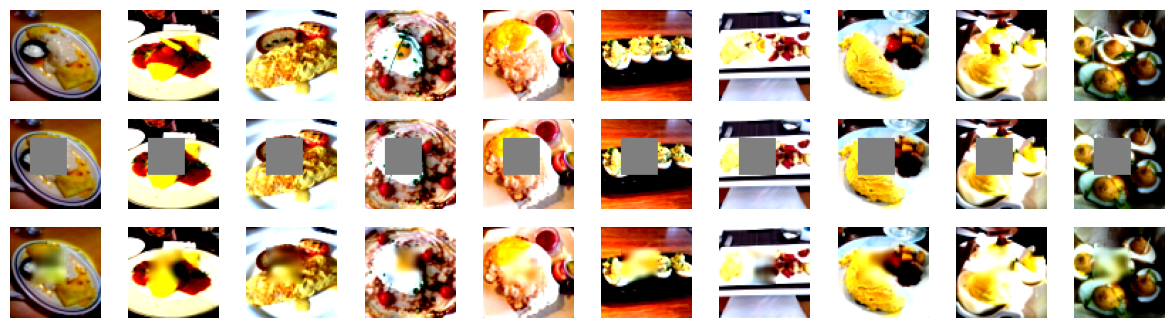

In [24]:
fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(denorm(images[i]).permute(1, 2, 0))
    axs[1, i].imshow(denorm(masked_images[i].permute(1, 2, 0)))
    axs[2, i].imshow(denorm(outputs[i].permute(1, 2, 0)))  
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
plt.show()

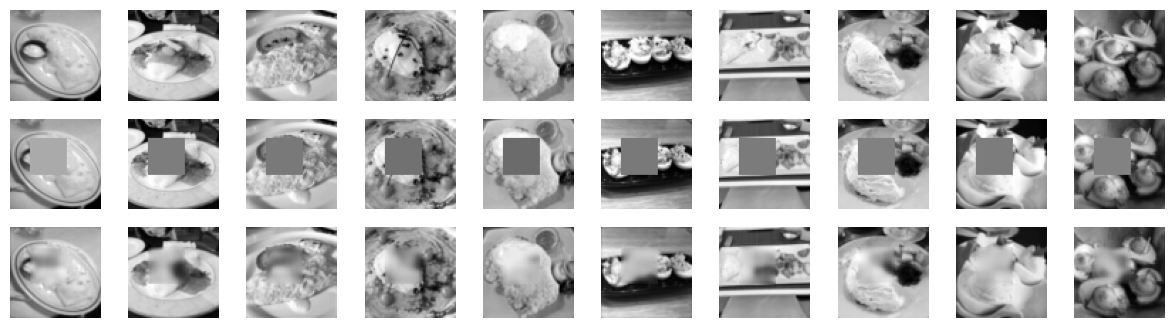

In [15]:
fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(denorm(images[i][0]), cmap='gray')
    axs[1, i].imshow(masked_images[i][0], cmap='gray')
    axs[2, i].imshow(outputs[i][0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
plt.show()

In [18]:
import torch

# 학습된 모델 저장
torch.save(model.state_dict(), 'model_weights.pth')

In [19]:
model = ResUNet()  # 동일한 구조의 모델
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # 평가 모드로 전환

C:\Users\com\AppData\Local\Temp\ipykernel_31132\3649735771.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


ResUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.0356864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.0356864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5857359..1.0172855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57480264..1.7277814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.404

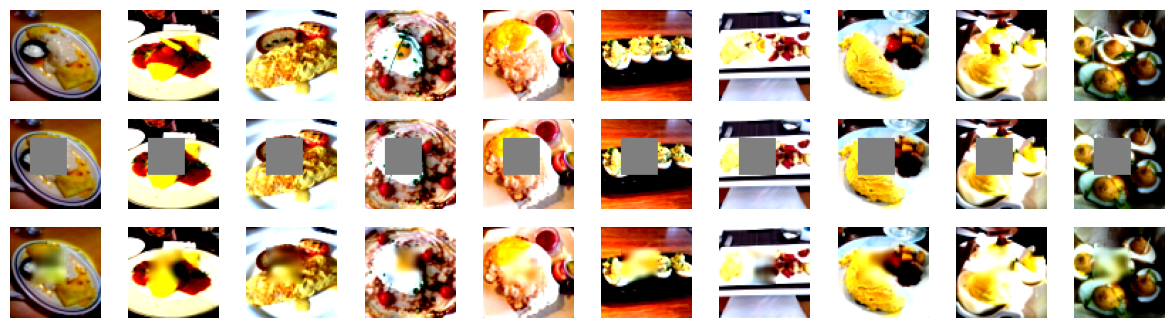

In [20]:
fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(denorm(images[i]).permute(1, 2, 0))
    axs[1, i].imshow(denorm(masked_images[i].permute(1, 2, 0)))
    axs[2, i].imshow(denorm(outputs[i].permute(1, 2, 0)))  
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
plt.show()

In [21]:
print(model)

ResUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 